In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.optimizers import SGD
from keras.optimizers import Adam
import numpy as np
from sklearn.datasets import fetch_lfw_pairs
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import optuna
from optuna import Trial
import plotly
import nbformat
import IPython
import ipywidgets



In [ ]:
data_augmentation = tf.keras.Sequential([           #data augmentation 
    layers.RandomFlip("horizontal"), 
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1)
]) 

lfw_pairs_train = fetch_lfw_pairs(subset='train',color=True)   #LFW dataset with colorful face images 62*47
pairs = lfw_pairs_train.pairs   
labels = lfw_pairs_train.target

augmented_pairs = []
augmented_labels = []

for i in range(len(pairs)):
    img1, img2 = pairs[i]
    label = labels[i]
    aug_img1 = data_augmentation(img1)
    aug_img2 = data_augmentation(img2)
    augmented_pairs.append([aug_img1.numpy(), aug_img2.numpy()])
    augmented_labels.append(label)

pairs_expanded = np.concatenate([pairs, np.array(augmented_pairs)], axis=0)
labels_expanded = np.concatenate([labels, np.array(augmented_labels)], axis=0)

pairs_train, pairs_test, labels_train, labels_test = train_test_split(           #params split for train ant validation
    pairs_expanded, labels_expanded, test_size=0.2, random_state=42, shuffle=True
)
pairs_train_full = pairs_train
labels_train_full = labels_train
pairs_train, pairs_val, labels_train, labels_val = train_test_split(            #params split for optuna train ant test
    pairs_train_full, labels_train_full, test_size=0.25, random_state=42, shuffle=True
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs", histogram_freq=1)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True
)


Generation pairs of images from LFW dataset extended with augmented variants

In [ ]:
def contrastive_loss(y_true, y_pred, margin=1.0):#loss function based on mean of euclid distance
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_mean(
        y_true * tf.square(y_pred) + 
        (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0))
    )
def residual_block(x, filters, kernel_size=3, stride=1):#ReSu blocks for deeper data collection and processing
    
    shortcut = x
        
    x = layers.Conv2D(filters, kernel_size, padding='same', strides=stride)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
        
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
        
    
    if shortcut.shape[-1] != filters or stride > 1:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
        
    x = layers.Add()([x, shortcut])
    return layers.ReLU()(x)

def encoder(input_shape, latent_dim,dropout_rate, l1, l2):#encoder function with input params for OPTUNA search
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, stride=2)  
    x = residual_block(x, 128)
    x = residual_block(x, 256, stride=2)  
    x = residual_block(x, 256)
    conv3 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    conv5 = layers.Conv2D(64, (5, 5), padding='same', activation='relu')(x)
    conv7 = layers.Conv2D(64, (7, 7), padding='same', activation='relu')(x)
    merged = layers.concatenate([conv3, conv5, conv7])
    attention = layers.Conv2D(192, (1,1), activation='sigmoid')(merged)
    weighted = layers.Multiply()([merged, attention])
    x = layers.GlobalAveragePooling2D()(weighted)
    x = layers.Dropout(dropout_rate)(x)
    latent = layers.Dense(
        latent_dim, 
        activation='relu',
        kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2),
        name='latent'
    )(x)
    return keras.Model(inputs, latent, name='encoder')

Funcs for encoder working and loss func

[I 2025-06-25 16:32:47,165] A new study created in memory with name: no-name-029ead66-268c-441e-bff0-254da10bf39a


  0%|          | 0/20 [00:00<?, ?it/s]


[I 2025-06-25 16:35:58,552] Trial 0 finished with value: 0.5621085271317829 and parameters: {'dropout_rate': 0.26636322115009226, 'latent_dim': 144, 'lr': 3.180311853549997e-05, 'l1': 0.00048246834579488584, 'l2': 0.00038222544637773337, 'optimizer': 'SGD', 'batch_size': 39}. Best is trial 0 with value: 0.5621085271317829.

[I 2025-06-25 16:40:36,616] Trial 1 finished with value: 0.5742480620155039 and parameters: {'dropout_rate': 0.6066657872847986, 'latent_dim': 224, 'lr': 0.00010330341602578039, 'l1': 1.4958642136446876e-06, 'l2': 1.0894585087465276e-05, 'optimizer': 'Adam', 'batch_size': 36}. Best is trial 1 with value: 0.5742480620155039.
[I 2025-06-25 16:45:47,323] Trial 2 finished with value: 0.6398914728682171 and parameters: {'dropout_rate': 0.4759706817071596, 'latent_dim': 192, 'lr': 0.0006363523818146127, 'l1': 5.0084388068179245e-05, 'l2': 9.564591094402305e-06, 'optimizer': 'Adam', 'batch_size': 67}. Best is trial 2 with value: 0.6398914728682171.
[I 2025-06-25 16:48:42,

C:\Users\ASUS\AppData\Local\Temp\ipykernel_16924\3650278920.py:49: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


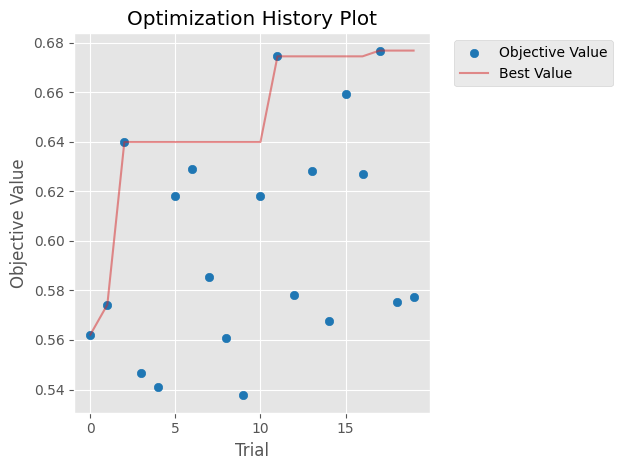

Best params: {'dropout_rate': 0.06515916535447766, 'latent_dim': 48, 'lr': 5.553392592638983e-05, 'l1': 3.066371061621236e-06, 'l2': 2.180541349246159e-05, 'optimizer': 'Adam', 'batch_size': 20}


In [ ]:
def objective(trial: Trial):#OPTUNA objective hyperparams search func
    
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.7)
    latent_dim = trial.suggest_int('latent_dim', 32, 256, step=16)
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    l1 = trial.suggest_float('l1', 1e-6, 1e-3, log=True)
    l2 = trial.suggest_float('l2', 1e-6, 1e-3, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
    batch_size = trial.suggest_int('batch_size', 16, 96)  

    encode = encoder(input_shape, latent_dim, dropout_rate, l1, l2)
    input_a = keras.Input(shape=input_shape)
    input_b = keras.Input(shape=input_shape)
    
    embedding_a = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(encode(input_a))
    embedding_b = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(encode(input_b))
    
    distance = layers.Lambda(lambda emb: tf.norm(emb[0] - emb[1], axis=1, keepdims=True))(
        [embedding_a, embedding_b]
    )
    siamese_model = keras.Model(inputs=[input_a, input_b], outputs=distance)
    
 
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    siamese_model.compile(optimizer=optimizer, loss=contrastive_loss, metrics=[])

    siamese_model.fit(
        [pairs_train[:, 0], pairs_train[:, 1]], labels_train,
        batch_size=batch_size,
        epochs=30,
        validation_data=([pairs_val[:, 0], pairs_val[:, 1]], labels_val),
        callbacks=[early_stopping, tensorboard_callback],
        verbose=0
    )
    
    distances_val = siamese_model.predict([pairs_val[:, 0], pairs_val[:, 1]], verbose=0)
    auc = roc_auc_score(labels_val, -distances_val)
    
    return auc  

input_shape = (62, 47, 3)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20,show_progress_bar=True)
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.tight_layout()
plt.show()
best_params = study.best_params
print(f"Best params: {best_params}")

OPTUNA's search history shows best params for autoencoder though to be more specific needed more trials

In [12]:
encode = encoder(
    input_shape, 
    best_params['latent_dim'], 
    best_params['dropout_rate'],
    best_params['l1'],
    best_params['l2']
)
input_a=keras.Input(shape=input_shape)
input_b=keras.Input(shape=input_shape)
embedding_a = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(encode(input_a))
embedding_b = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(encode(input_b))
distance = layers.Lambda(lambda emb: tf.norm(emb[0] - emb[1], axis=1, keepdims=True))(
    [embedding_a, embedding_b]
)
siamese_model = keras.Model(inputs=[input_a, input_b], outputs=distance)
best_optimizer_name = best_params['optimizer']
best_lr = best_params['lr']
if best_optimizer_name == 'Adam':
    optimizer = Adam(learning_rate=best_lr)
else:
    optimizer = SGD(learning_rate=best_lr)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',    
    factor=0.25,          
    patience=3,           
    min_lr=1e-7,
    verbose=1          
)
siamese_model.compile(optimizer=optimizer, loss=contrastive_loss, metrics=[])
history_new=siamese_model.fit(
    [pairs_test[:, 0], pairs_test[:, 1]], labels_test,
    batch_size=best_params['batch_size'],
    epochs=20,
    verbose=1,
    validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
    callbacks=[tensorboard_callback,early_stopping,reduce_lr]
    
)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 268ms/step - loss: 0.2537 - val_loss: 0.5022 - learning_rate: 5.5534e-05
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - loss: 0.2364 - val_loss: 0.5007 - learning_rate: 5.5534e-05
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - loss: 0.1815 - val_loss: 0.4947 - learning_rate: 5.5534e-05
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - loss: 0.1453 - val_loss: 0.4646 - learning_rate: 5.5534e-05
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - loss: 0.1148 - val_loss: 0.4079 - learning_rate: 5.5534e-05
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - loss: 0.0974 - val_loss: 0.3295 - learning_rate: 5.5534e-05
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - loss: 0.0773 - val_loss: 0.3065 - learning_rate: 5.5534e-05
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - loss: 0.0620 - val_loss: 0.2314 - learning_rate: 5.5534e-05
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - loss: 0.0476 - val_loss: 0.2139 -

val_loss on high epochs can be also triggered as overteaching but ROC AUC show that it just due to normalazing data and also due to general low data quantity

In [10]:
distances_test = siamese_model.predict([pairs_test[:, 0], pairs_test[:, 1]])
auc = roc_auc_score(labels_test, -distances_test)
print(f"Final Test AUC: {auc:.4f}")


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step
Final Test AUC: 0.8481


ROC AUC results can be highly depend on the quality and quantity of data and using OPTUNA search accuraccy can mostly be raised due to improvments of input data 

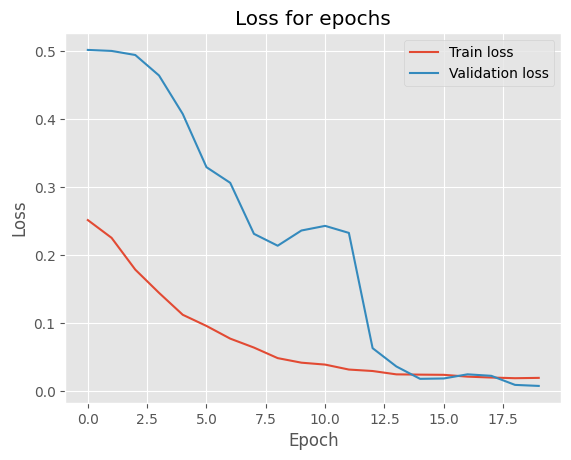

In [14]:
plt.plot(history_new.history['loss'], label='Train loss')
plt.plot(history_new.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss for epochs')
plt.legend()
plt.show()






loss for epochs graphs and ROC AUC stats shows almost smooth fall function due to ReduceLROnPlateau callback

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


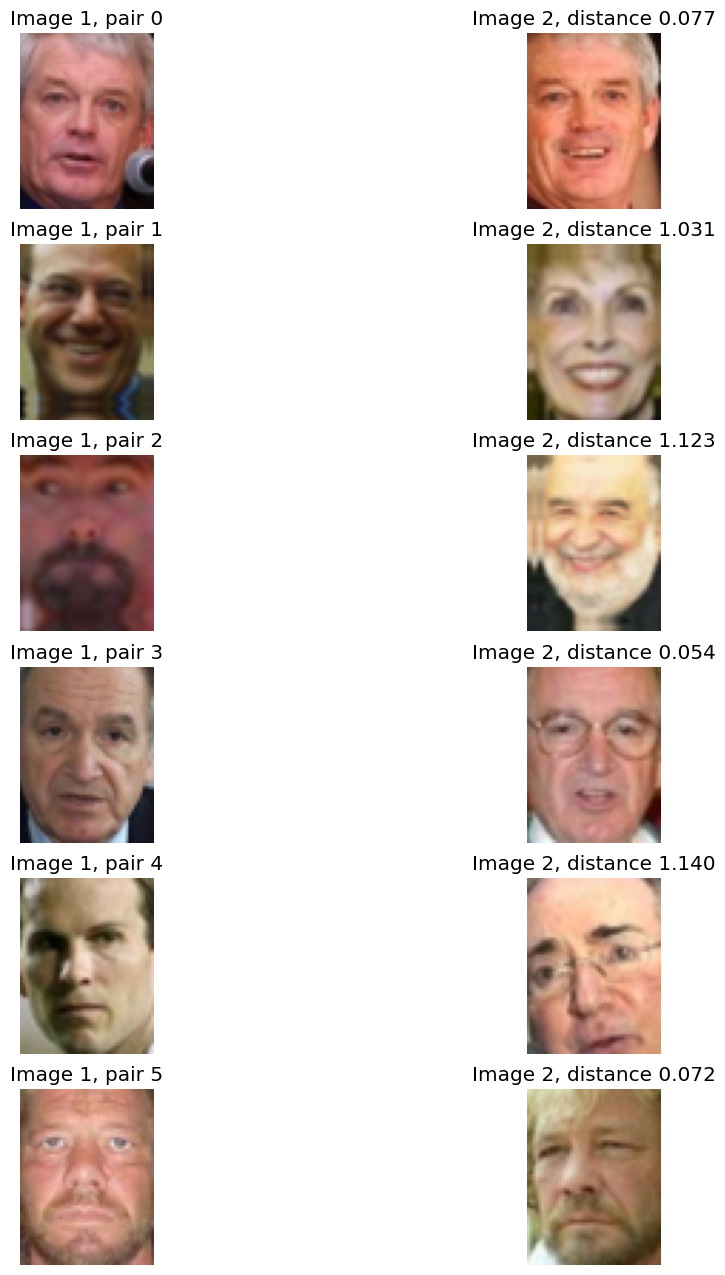

In [16]:

plt.figure(figsize=(12, 16))
for im in range(6):  
    img1 = pairs_test[im][0]
    img2 = pairs_test[im][1]
    img1_batch = img1[np.newaxis, ...]
    img2_batch = img2[np.newaxis, ...]
    distance_val = siamese_model.predict([img1_batch, img2_batch])
    plt.subplot(6, 2, 2*im+1)
    plt.imshow(img1.squeeze(), cmap='gray')
    plt.title(f'Image 1, pair {im}')
    plt.axis('off')
    plt.subplot(6, 2, 2*im+2)
    plt.imshow(img2.squeeze(), cmap='gray')
    plt.title(f'Image 2, distance {distance_val[0][0]:.3f}')
    plt.axis('off')
plt.show()

example of working 

so to get better ROC AUC and distance with greater feature detection (as we see different images on pct 1 and 2 although with distance<1) need better dataset with greater amount of images and deeper cores in encoder functions 